In [2]:
# Guangkuo Liu, Yifan Zhang

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from typing import Optional
import time
from PIL import Image

# Import our improved model
from improved_enhanced_cnn import (
    ImprovedCNNAutoencoder, 
    create_local_model, 
    create_global_model,
    HybridLoss,
    ProgressiveLoss
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Training parameters
TF_TEST = 0.3  # Standard test noise level
TF_HIGH = 1.0  # High noise level (pure noise)
R_TEST = 2     # Receptive field radius

# Model parameters
EMB_DIM = 64
BASE_CHANNELS = 16
BATCH_SIZE = 256  # Smaller for more stable training
EPOCHS = 15
LR = 0.0005  # Lower learning rate for better convergence

# 1. Prerequisite

## 1.1 Model Creation and Comparison

In [4]:
# Create both local and global models

local_model = create_local_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

global_model = create_global_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

local_params = sum(p.numel() for p in local_model.parameters())
global_params = sum(p.numel() for p in global_model.parameters())

print(f"\nLocal model (R_INTERNAL=0):  {local_params:,} parameters")
print(f"Global model (R_INTERNAL=1): {global_params:,} parameters")
print(f"Difference: {global_params - local_params:,} parameters")

# Test forward pass
test_input = torch.randn(2, 1, 28, 28).to(device)
test_t = torch.tensor([0.3, 1.0]).to(device)

with torch.no_grad():
    local_output = local_model(test_input, test_t)
    global_output = global_model(test_input, test_t)
    
print(f"\nLocal model output: {local_output.shape}")
print(f"Global model output: {global_output.shape}")

Creating LOCAL model (R_INTERNAL=0)
Model created: 276,881 parameters
Creating GLOBAL model (R_INTERNAL=3)
Model created: 7,714,388 parameters

Local model (R_INTERNAL=0):  276,881 parameters
Global model (R_INTERNAL=1): 7,714,388 parameters
Difference: 7,437,507 parameters

Local model output: torch.Size([2, 1, 28, 28])
Global model output: torch.Size([2, 1, 28, 28])


## 1.2 Data Loading and Utility Functions

In [ ]:
# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=False, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=False, transform=transform
)

# Split training set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset loaded:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

Dataset loaded:
  Training: 48000 samples
  Validation: 12000 samples
  Test: 10000 samples


In [ ]:
# Utility functions
def linear_interpolate_to_noise(images, tf):
    """Linearly interpolate between images and noise based on tf"""
    noise = torch.randn_like(images)
    return (1 - tf) * images + tf * noise

def create_coordinate_channels(batch_size, height, width, device):
    """Create x and y coordinate channels normalized between -1 and 1"""
    y_coords = torch.linspace(-1, 1, height).view(1, 1, height, 1).expand(batch_size, 1, height, width)
    x_coords = torch.linspace(-1, 1, width).view(1, 1, 1, width).expand(batch_size, 1, height, width)
    return x_coords.to(device), y_coords.to(device)

def create_time_channel(batch_size, height, width, tf_values, device):
    """Create time channel with tf values (0 to 1) for each image"""
    time_channel = tf_values.view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width)
    return time_channel.to(device)

def prepare_input_with_coords_and_time(images, tf_values):
    """Combine Fashion MNIST images with coordinate and time channels (legacy format)"""
    batch_size, _, height, width = images.shape
    x_coords, y_coords = create_coordinate_channels(batch_size, height, width, images.device)
    time_channel = create_time_channel(batch_size, height, width, tf_values, images.device)
    return torch.cat([images, x_coords, y_coords, time_channel], dim=1)

## 1.3 Curriculum Learning Training Strategy

In [13]:
class CurriculumScheduler:
    """Curriculum learning scheduler that gradually increases noise difficulty."""
    
    def __init__(self, total_epochs: int, start_tf: float = 0.1, end_tf: float = 1.0,
                 warmup_epochs: int = 5):
        self.total_epochs = total_epochs
        self.start_tf = start_tf
        self.end_tf = end_tf
        self.warmup_epochs = warmup_epochs
        
    def get_noise_range(self, epoch: int):
        """Get the noise range for current epoch."""
        if epoch < self.warmup_epochs:
            # Warmup: only use low noise
            max_tf = self.start_tf + (0.3 - self.start_tf) * (epoch / self.warmup_epochs)
            return self.start_tf, max_tf
        else:
            # Progressive: gradually increase max noise
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            max_tf = 0.3 + (self.end_tf - 0.3) * progress
            return self.start_tf, min(max_tf, self.end_tf)
    
    def sample_noise_levels(self, batch_size: int, epoch: int, device) -> torch.Tensor:
        """Sample noise levels for current epoch."""
        min_tf, max_tf = self.get_noise_range(epoch)
        
        # Sample uniformly in the allowed range
        tf_values = torch.rand(batch_size, device=device) * (max_tf - min_tf) + min_tf
        return tf_values

# Create curriculum schedulers
curriculum_scheduler = CurriculumScheduler(total_epochs=EPOCHS, warmup_epochs=3)

print("Curriculum scheduler created")
print("Noise level progression:")
for epoch in [0, 2, 5, 10, 15, 19]:
    min_tf, max_tf = curriculum_scheduler.get_noise_range(epoch)
    print(f"  Epoch {epoch:2d}: TF range [{min_tf:.2f}, {max_tf:.2f}]")

Curriculum scheduler created
Noise level progression:
  Epoch  0: TF range [0.10, 0.10]
  Epoch  2: TF range [0.10, 0.23]
  Epoch  5: TF range [0.10, 0.42]
  Epoch 10: TF range [0.10, 0.71]
  Epoch 15: TF range [0.10, 1.00]
  Epoch 19: TF range [0.10, 1.00]


# 2. DDIM Training and Generation

## Noise Prediction Training & DDIM-Style Generation

This section implements:
- **Noise Prediction Training**: Train models to predict the noise component z in noisy_img = (1-t)*img + t*z
- **DDIM-Style Generation**: Multi-step denoising process that iteratively refines noisy images
- **Adaptive Timestep Sampling**: Flexible timestep scheduling for generation

In [14]:
def train_noise_prediction_model(model, model_name, train_loader, val_loader, 
                                curriculum_scheduler, epochs=EPOCHS, lr=LR):
    """Train model to predict noise z where noisy_img = (1-t)*img + t*z"""
    
    # Setup training
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()  # Direct MSE on noise prediction
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=4, verbose=True, min_lr=1e-6
    )
    
    train_losses = []
    val_losses = []
    learning_rates = []
    
    # Create save directory
    save_dir = f"./results/{model_name.lower()}_noise_pred/"
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nStarting {model_name} Noise Prediction Training")
    print(f"Save directory: {save_dir}")
    print(f"Target: Predict noise z in noisy_img = (1-t)*img + t*z")
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Get noise range for this epoch
        min_tf, max_tf = curriculum_scheduler.get_noise_range(epoch)
        
        print(f"\nEpoch {epoch+1}/{epochs} - TF range: [{min_tf:.2f}, {max_tf:.2f}], LR: {current_lr:.1e}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'{model_name} Noise Train')
        
        for batch_idx, (images, _) in enumerate(train_pbar):
            images = images.to(device)
            batch_size = images.size(0)
            
            # Sample noise levels using curriculum
            tf_values = curriculum_scheduler.sample_noise_levels(batch_size, epoch, device)
            
            # Generate noise and create noisy images
            noise = torch.randn_like(images)
            noisy_images = torch.zeros_like(images)
            for i in range(batch_size):
                t = tf_values[i]
                noisy_images[i] = (1 - t) * images[i] + t * noise[i]
            
            # Forward pass - predict the noise
            optimizer.zero_grad()
            predicted_noise = model(noisy_images, tf_values, noise_level=tf_values)
            
            # Loss: MSE between predicted noise and actual noise
            loss = criterion(predicted_noise, noise)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'TF_avg': f'{tf_values.mean():.2f}',
                'Noise_std': f'{predicted_noise.std():.3f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'{model_name} Noise Val')
        
        with torch.no_grad():
            for images, _ in val_pbar:
                images = images.to(device)
                batch_size = images.size(0)
                
                # Use same noise range as training for validation
                tf_values = curriculum_scheduler.sample_noise_levels(batch_size, epoch, device)
                
                # Generate noise and noisy images
                noise = torch.randn_like(images)
                noisy_images = torch.zeros_like(images)
                for i in range(batch_size):
                    t = tf_values[i]
                    noisy_images[i] = (1 - t) * images[i] + t * noise[i]
                
                predicted_noise = model(noisy_images, tf_values, noise_level=tf_values)
                loss = criterion(predicted_noise, noise)
                val_loss += loss.item()
                
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'training_type': 'noise_prediction',
                'model_config': {
                    'model_name': model_name,
                    'r_internal': model.r_internal,
                    'receptive_field_radius': model.receptive_field_radius,
                    'is_global': model.is_global
                }
            }, os.path.join(save_dir, f'best_{model_name.lower()}_noise_pred.pth'))
            print(f"  Best noise prediction model saved (val_loss: {avg_val_loss:.6f})")
        
        print(f"  Train Loss: {avg_train_loss:.6f}")
        print(f"  Val Loss: {avg_val_loss:.6f}")
    
    print(f"\n{model_name} noise prediction training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses, learning_rates

In [15]:
def euler_generation(model, noisy_images, start_tf=1.0, end_tf=0.0, num_steps=100):
    """
    Euler method generation: uses small time steps dt and subtracts dt*noise at each step.
    
    Based on the differential equation formulation:
    dx/dt = -noise_prediction(x, t)
    
    Args:
        model: Trained noise prediction model
        noisy_images: Initial noisy images 
        start_tf: Starting noise level (1.0 = pure noise, 0.0 = clean)
        end_tf: Target noise level (usually 0.0 for clean images)
        num_steps: Number of small Euler steps
    
    Returns:
        denoised_images: Final denoised images
        intermediate_images: List of images at each step
    """
    model.eval()
    device = noisy_images.device
    batch_size = noisy_images.size(0)
    
    # Calculate step size
    dt = (start_tf - end_tf) / num_steps
    
    current_images = noisy_images.clone()
    current_t = start_tf
    intermediate_images = [current_images.clone()]
    
    print(f"Euler Generation: {num_steps} steps with dt={dt:.4f} from TF={start_tf:.2f} to TF={end_tf:.2f}")
    
    with torch.no_grad():
        pbar = tqdm(range(num_steps), desc="Euler Steps")
        for i in pbar:
            # Create current timestep tensor
            t_tensor = torch.full((batch_size,), current_t, device=device)
            
            # Predict noise at current timestep and current image
            predicted_noise = model(current_images, t_tensor, noise_level=t_tensor)
            
            # Euler step: x_{t+dt} = x_t - dt * noise_prediction(x_t, t)
            # This moves us in the direction of reducing noise
            current_images = current_images - dt * predicted_noise
            
            # Update time
            current_t = current_t - dt
            
            # Clamp to valid image range
            current_images = torch.clamp(current_images, 0.0, 1.0)
            
            # Store intermediate result every few steps
            if i % max(1, num_steps // 10) == 0 or i == num_steps - 1:
                intermediate_images.append(current_images.clone())
            
            # Update progress bar
            pbar.set_postfix({
                'TF': f'{current_t:.3f}',
                'Noise_std': f'{predicted_noise.std():.3f}',
                'Img_range': f'[{current_images.min():.2f}, {current_images.max():.2f}]'
            })
    
    print(f"Euler generation completed!")
    return current_images, intermediate_images

# 3. DDIM Scan $r$

## 3.1 Training for different $r$

In [ ]:
# Experiment parameters

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]

#r = r_ini + sum(r_internal *2)

SCAN_EPOCHS = 15  # Fewer epochs for scanning experiment
SCAN_LR = 0.001  # Learning rate for scanning

# Storage for results
radius_scan_results = {}

# Create results directory for radius scan
radius_scan_dir = "./model-gen/"
os.makedirs(radius_scan_dir, exist_ok=True)

for r_idx,r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\n{'='*60}")
    print(f"TRAINING LOCAL MODEL WITH R_TEST = {r_test}, R_INTERNAL_LIST_RANGE = {R_INTERNAL_LIST_RANGE[r_idx]}")
    print(f"{'='*60}")

    r_initial = r_test % 2
    
    # Create local model with current receptive field radius
    current_local_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
    
    print(f"Created local model with R_TEST={r_test}")
    print(f"Model parameters: {sum(p.numel() for p in current_local_model.parameters()):,}")
    
    # Train the model with noise prediction
    start_time = time.time()
    train_losses, val_losses, learning_rates = train_noise_prediction_model(
        current_local_model, f"Local_R{r_test}", train_loader, val_loader, 
        curriculum_scheduler, epochs=SCAN_EPOCHS, lr=SCAN_LR
    )
    training_time = time.time() - start_time
    
    # Save the trained model
    model_save_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    torch.save({
        'model_state_dict': current_local_model.state_dict(),
        'r_test': r_test,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'training_time': training_time,
        'model_config': {
            'receptive_field_radius': r_test,
            'emb_dim': EMB_DIM,
            'base_channels': BASE_CHANNELS,
            'epochs': SCAN_EPOCHS,
            'lr': SCAN_LR
        }
    }, model_save_path)

/home/logtenk/anaconda3/envs/llmenv4/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



TRAINING LOCAL MODEL WITH R_TEST = 1, R_INTERNAL_LIST_RANGE = [0, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Created local model with R_TEST=1
Model parameters: 276,625

Starting Local_R1 Noise Prediction Training
Save directory: ./results/local_r1_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.34it/s, Loss=0.2243]


  Best noise prediction model saved (val_loss: 0.223924)
  Train Loss: 0.309542
  Val Loss: 0.223924

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.77it/s, Loss=0.1819]


  Best noise prediction model saved (val_loss: 0.181789)
  Train Loss: 0.188663
  Val Loss: 0.181789

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.80it/s, Loss=0.1591]


  Best noise prediction model saved (val_loss: 0.159392)
  Train Loss: 0.160680
  Val Loss: 0.159392

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.51it/s, Loss=0.1419]


  Best noise prediction model saved (val_loss: 0.140828)
  Train Loss: 0.142642
  Val Loss: 0.140828

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.42it/s, Loss=0.1302]


  Best noise prediction model saved (val_loss: 0.129662)
  Train Loss: 0.130754
  Val Loss: 0.129662

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.93it/s, Loss=0.1193]


  Best noise prediction model saved (val_loss: 0.120263)
  Train Loss: 0.121170
  Val Loss: 0.120263

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s, Loss=0.1156]


  Best noise prediction model saved (val_loss: 0.112729)
  Train Loss: 0.113208
  Val Loss: 0.112729

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.29it/s, Loss=0.1027]


  Best noise prediction model saved (val_loss: 0.105701)
  Train Loss: 0.105177
  Val Loss: 0.105701

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.97it/s, Loss=0.0914]


  Best noise prediction model saved (val_loss: 0.097552)
  Train Loss: 0.097569
  Val Loss: 0.097552

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.98it/s, Loss=0.0918]


  Best noise prediction model saved (val_loss: 0.090007)
  Train Loss: 0.090785
  Val Loss: 0.090007

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.86it/s, Loss=0.0825]


  Best noise prediction model saved (val_loss: 0.084540)
  Train Loss: 0.084185
  Val Loss: 0.084540

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 15.63it/s, Loss=0.0840]


  Best noise prediction model saved (val_loss: 0.077485)
  Train Loss: 0.077782
  Val Loss: 0.077485

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 15.57it/s, Loss=0.0765]


  Best noise prediction model saved (val_loss: 0.071936)
  Train Loss: 0.072124
  Val Loss: 0.071936

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 16.54it/s, Loss=0.0644]


  Best noise prediction model saved (val_loss: 0.067318)
  Train Loss: 0.067375
  Val Loss: 0.067318

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.96it/s, Loss=0.0653]


  Best noise prediction model saved (val_loss: 0.062487)
  Train Loss: 0.062356
  Val Loss: 0.062487

Local_R1 noise prediction training completed!
Best validation loss: 0.062487

TRAINING LOCAL MODEL WITH R_TEST = 2, R_INTERNAL_LIST_RANGE = [1, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Created local model with R_TEST=2
Model parameters: 296,977

Starting Local_R2 Noise Prediction Training
Save directory: ./results/local_r2_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.91it/s, Loss=0.1856]


  Best noise prediction model saved (val_loss: 0.184326)
  Train Loss: 0.245418
  Val Loss: 0.184326

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.69it/s, Loss=0.1470]


  Best noise prediction model saved (val_loss: 0.148420)
  Train Loss: 0.153389
  Val Loss: 0.148420

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.83it/s, Loss=0.1247]


  Best noise prediction model saved (val_loss: 0.126622)
  Train Loss: 0.129352
  Val Loss: 0.126622

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 15.82it/s, Loss=0.1099]


  Best noise prediction model saved (val_loss: 0.108788)
  Train Loss: 0.111634
  Val Loss: 0.108788

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.87it/s, Loss=0.0955]


  Best noise prediction model saved (val_loss: 0.097848)
  Train Loss: 0.098725
  Val Loss: 0.097848

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 15.09it/s, Loss=0.0932]


  Best noise prediction model saved (val_loss: 0.087734)
  Train Loss: 0.089420
  Val Loss: 0.087734

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.90it/s, Loss=0.0827]


  Best noise prediction model saved (val_loss: 0.080347)
  Train Loss: 0.081197
  Val Loss: 0.080347

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.74it/s, Loss=0.0749]


  Best noise prediction model saved (val_loss: 0.074722)
  Train Loss: 0.074558
  Val Loss: 0.074722

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.75it/s, Loss=0.0667]


  Best noise prediction model saved (val_loss: 0.067815)
  Train Loss: 0.067870
  Val Loss: 0.067815

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.85it/s, Loss=0.0565]


  Best noise prediction model saved (val_loss: 0.062426)
  Train Loss: 0.062614
  Val Loss: 0.062426

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.77it/s, Loss=0.0576]


  Best noise prediction model saved (val_loss: 0.057798)
  Train Loss: 0.057765
  Val Loss: 0.057798

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.81it/s, Loss=0.0514]


  Best noise prediction model saved (val_loss: 0.053199)
  Train Loss: 0.053455
  Val Loss: 0.053199

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.73it/s, Loss=0.0495]


  Best noise prediction model saved (val_loss: 0.048661)
  Train Loss: 0.049007
  Val Loss: 0.048661

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.80it/s, Loss=0.0466]


  Best noise prediction model saved (val_loss: 0.045790)
  Train Loss: 0.045644
  Val Loss: 0.045790

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.72it/s, Loss=0.0450]


  Best noise prediction model saved (val_loss: 0.042149)
  Train Loss: 0.042822
  Val Loss: 0.042149

Local_R2 noise prediction training completed!
Best validation loss: 0.042149

TRAINING LOCAL MODEL WITH R_TEST = 3, R_INTERNAL_LIST_RANGE = [1, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Created local model with R_TEST=3
Model parameters: 297,105

Starting Local_R3 Noise Prediction Training
Save directory: ./results/local_r3_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.61it/s, Loss=0.1847]


  Best noise prediction model saved (val_loss: 0.186078)
  Train Loss: 0.246913
  Val Loss: 0.186078

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.73it/s, Loss=0.1494]


  Best noise prediction model saved (val_loss: 0.150094)
  Train Loss: 0.153972
  Val Loss: 0.150094

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.74it/s, Loss=0.1229]


  Best noise prediction model saved (val_loss: 0.126008)
  Train Loss: 0.128916
  Val Loss: 0.126008

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.86it/s, Loss=0.1088]


  Best noise prediction model saved (val_loss: 0.107858)
  Train Loss: 0.110414
  Val Loss: 0.107858

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.78it/s, Loss=0.0959]


  Best noise prediction model saved (val_loss: 0.095717)
  Train Loss: 0.097658
  Val Loss: 0.095717

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=0.0873]


  Best noise prediction model saved (val_loss: 0.086876)
  Train Loss: 0.087708
  Val Loss: 0.086876

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=0.0804]


  Best noise prediction model saved (val_loss: 0.078963)
  Train Loss: 0.079732
  Val Loss: 0.078963

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 15.43it/s, Loss=0.0660]


  Best noise prediction model saved (val_loss: 0.072504)
  Train Loss: 0.072890
  Val Loss: 0.072504

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.65it/s, Loss=0.0656]


  Best noise prediction model saved (val_loss: 0.066907)
  Train Loss: 0.067100
  Val Loss: 0.066907

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.68it/s, Loss=0.0618]


  Best noise prediction model saved (val_loss: 0.060880)
  Train Loss: 0.061492
  Val Loss: 0.060880

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.74it/s, Loss=0.0590]


  Best noise prediction model saved (val_loss: 0.056961)
  Train Loss: 0.056431
  Val Loss: 0.056961

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.66it/s, Loss=0.0520]


  Best noise prediction model saved (val_loss: 0.052451)
  Train Loss: 0.052048
  Val Loss: 0.052451

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 15.49it/s, Loss=0.0443]


  Best noise prediction model saved (val_loss: 0.048545)
  Train Loss: 0.048333
  Val Loss: 0.048545

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.78it/s, Loss=0.0457]


  Best noise prediction model saved (val_loss: 0.044482)
  Train Loss: 0.044935
  Val Loss: 0.044482

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.78it/s, Loss=0.0435]


  Best noise prediction model saved (val_loss: 0.041998)
  Train Loss: 0.041993
  Val Loss: 0.041998

Local_R3 noise prediction training completed!
Best validation loss: 0.041998

TRAINING LOCAL MODEL WITH R_TEST = 4, R_INTERNAL_LIST_RANGE = [1, 1, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Created local model with R_TEST=4
Model parameters: 378,897

Starting Local_R4 Noise Prediction Training
Save directory: ./results/local_r4_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.67it/s, Loss=0.1723]


  Best noise prediction model saved (val_loss: 0.174333)
  Train Loss: 0.231291
  Val Loss: 0.174333

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.81it/s, Loss=0.1381]


  Best noise prediction model saved (val_loss: 0.138065)
  Train Loss: 0.144052
  Val Loss: 0.138065

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.71it/s, Loss=0.1134]


  Best noise prediction model saved (val_loss: 0.116110)
  Train Loss: 0.119500
  Val Loss: 0.116110

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.73it/s, Loss=0.0972]


  Best noise prediction model saved (val_loss: 0.102402)
  Train Loss: 0.102702
  Val Loss: 0.102402

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.63it/s, Loss=0.0928]


  Best noise prediction model saved (val_loss: 0.089932)
  Train Loss: 0.090850
  Val Loss: 0.089932

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.57it/s, Loss=0.0825]


  Best noise prediction model saved (val_loss: 0.081087)
  Train Loss: 0.081586
  Val Loss: 0.081087

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.76it/s, Loss=0.0719]


  Best noise prediction model saved (val_loss: 0.072604)
  Train Loss: 0.073587
  Val Loss: 0.072604

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.70it/s, Loss=0.0610]


  Best noise prediction model saved (val_loss: 0.065881)
  Train Loss: 0.067177
  Val Loss: 0.065881

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.70it/s, Loss=0.0644]


  Best noise prediction model saved (val_loss: 0.061637)
  Train Loss: 0.061288
  Val Loss: 0.061637

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.63it/s, Loss=0.0506]


  Best noise prediction model saved (val_loss: 0.055982)
  Train Loss: 0.056153
  Val Loss: 0.055982

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.63it/s, Loss=0.0450]


  Best noise prediction model saved (val_loss: 0.050355)
  Train Loss: 0.051667
  Val Loss: 0.050355

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.56it/s, Loss=0.0439]


  Best noise prediction model saved (val_loss: 0.047462)
  Train Loss: 0.047528
  Val Loss: 0.047462

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.42it/s, Loss=0.0475]


  Best noise prediction model saved (val_loss: 0.043295)
  Train Loss: 0.043772
  Val Loss: 0.043295

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.22it/s, Loss=0.0427]


  Best noise prediction model saved (val_loss: 0.040086)
  Train Loss: 0.040273
  Val Loss: 0.040086

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.45it/s, Loss=0.0358]


  Best noise prediction model saved (val_loss: 0.037996)
  Train Loss: 0.037709
  Val Loss: 0.037996

Local_R4 noise prediction training completed!
Best validation loss: 0.037996

TRAINING LOCAL MODEL WITH R_TEST = 5, R_INTERNAL_LIST_RANGE = [1, 1, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Created local model with R_TEST=5
Model parameters: 379,025

Starting Local_R5 Noise Prediction Training
Save directory: ./results/local_r5_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 14.34it/s, Loss=0.1732]


  Best noise prediction model saved (val_loss: 0.175389)
  Train Loss: 0.254809
  Val Loss: 0.175389

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.98it/s, Loss=0.1353]


  Best noise prediction model saved (val_loss: 0.138318)
  Train Loss: 0.145250
  Val Loss: 0.138318

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.60it/s, Loss=0.1164]


  Best noise prediction model saved (val_loss: 0.116812)
  Train Loss: 0.120281
  Val Loss: 0.116812

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.52it/s, Loss=0.0984]


  Best noise prediction model saved (val_loss: 0.099688)
  Train Loss: 0.102908
  Val Loss: 0.099688

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.46it/s, Loss=0.0911]


  Best noise prediction model saved (val_loss: 0.088683)
  Train Loss: 0.090057
  Val Loss: 0.088683

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.58it/s, Loss=0.0800]


  Best noise prediction model saved (val_loss: 0.080733)
  Train Loss: 0.081005
  Val Loss: 0.080733

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.52it/s, Loss=0.0752]


  Best noise prediction model saved (val_loss: 0.073231)
  Train Loss: 0.073267
  Val Loss: 0.073231

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.47it/s, Loss=0.0640]


  Best noise prediction model saved (val_loss: 0.065323)
  Train Loss: 0.067003
  Val Loss: 0.065323

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.78it/s, Loss=0.0578]


  Best noise prediction model saved (val_loss: 0.060108)
  Train Loss: 0.061359
  Val Loss: 0.060108

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.62it/s, Loss=0.0548]


  Best noise prediction model saved (val_loss: 0.054806)
  Train Loss: 0.055552
  Val Loss: 0.054806

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.71it/s, Loss=0.0531]


  Best noise prediction model saved (val_loss: 0.051343)
  Train Loss: 0.051267
  Val Loss: 0.051343

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.74it/s, Loss=0.0424]


  Best noise prediction model saved (val_loss: 0.047704)
  Train Loss: 0.047596
  Val Loss: 0.047704

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.44it/s, Loss=0.0470]


  Best noise prediction model saved (val_loss: 0.044069)
  Train Loss: 0.043856
  Val Loss: 0.044069

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.66it/s, Loss=0.0412]


  Best noise prediction model saved (val_loss: 0.040078)
  Train Loss: 0.040847
  Val Loss: 0.040078

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.37it/s, Loss=0.0377]


  Best noise prediction model saved (val_loss: 0.037560)
  Train Loss: 0.037960
  Val Loss: 0.037560

Local_R5 noise prediction training completed!
Best validation loss: 0.037560

TRAINING LOCAL MODEL WITH R_TEST = 6, R_INTERNAL_LIST_RANGE = [1, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Created local model with R_TEST=6
Model parameters: 706,577

Starting Local_R6 Noise Prediction Training
Save directory: ./results/local_r6_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s, Loss=0.1712]


  Best noise prediction model saved (val_loss: 0.173975)
  Train Loss: 0.247490
  Val Loss: 0.173975

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.63it/s, Loss=0.1304]


  Best noise prediction model saved (val_loss: 0.132186)
  Train Loss: 0.137128
  Val Loss: 0.132186

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s, Loss=0.1094]


  Best noise prediction model saved (val_loss: 0.108689)
  Train Loss: 0.111862
  Val Loss: 0.108689

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.88it/s, Loss=0.0954]


  Best noise prediction model saved (val_loss: 0.094894)
  Train Loss: 0.095643
  Val Loss: 0.094894

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.99it/s, Loss=0.0754]


  Best noise prediction model saved (val_loss: 0.082272)
  Train Loss: 0.084144
  Val Loss: 0.082272

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s, Loss=0.0697]


  Best noise prediction model saved (val_loss: 0.073819)
  Train Loss: 0.075403
  Val Loss: 0.073819

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s, Loss=0.0733]


  Best noise prediction model saved (val_loss: 0.068019)
  Train Loss: 0.067884
  Val Loss: 0.068019

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.94it/s, Loss=0.0613]


  Best noise prediction model saved (val_loss: 0.060398)
  Train Loss: 0.061533
  Val Loss: 0.060398

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s, Loss=0.0538]


  Best noise prediction model saved (val_loss: 0.056247)
  Train Loss: 0.056080
  Val Loss: 0.056247

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.79it/s, Loss=0.0489]


  Best noise prediction model saved (val_loss: 0.050986)
  Train Loss: 0.051598
  Val Loss: 0.050986

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s, Loss=0.0447]


  Best noise prediction model saved (val_loss: 0.046304)
  Train Loss: 0.047094
  Val Loss: 0.046304

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.85it/s, Loss=0.0398]


  Best noise prediction model saved (val_loss: 0.043064)
  Train Loss: 0.043467
  Val Loss: 0.043064

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.87it/s, Loss=0.0354]


  Best noise prediction model saved (val_loss: 0.039886)
  Train Loss: 0.040084
  Val Loss: 0.039886

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.65it/s, Loss=0.0355]


  Best noise prediction model saved (val_loss: 0.036973)
  Train Loss: 0.037239
  Val Loss: 0.036973

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.66it/s, Loss=0.0308]


  Best noise prediction model saved (val_loss: 0.034861)
  Train Loss: 0.034727
  Val Loss: 0.034861

Local_R6 noise prediction training completed!
Best validation loss: 0.034861

TRAINING LOCAL MODEL WITH R_TEST = 7, R_INTERNAL_LIST_RANGE = [1, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Created local model with R_TEST=7
Model parameters: 706,705

Starting Local_R7 Noise Prediction Training
Save directory: ./results/local_r7_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.94it/s, Loss=0.1705]


  Best noise prediction model saved (val_loss: 0.173321)
  Train Loss: 0.244222
  Val Loss: 0.173321

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.86it/s, Loss=0.1292]


  Best noise prediction model saved (val_loss: 0.130914)
  Train Loss: 0.140372
  Val Loss: 0.130914

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.76it/s, Loss=0.1095]


  Best noise prediction model saved (val_loss: 0.110311)
  Train Loss: 0.113126
  Val Loss: 0.110311

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.71it/s, Loss=0.0962]


  Best noise prediction model saved (val_loss: 0.096232)
  Train Loss: 0.096333
  Val Loss: 0.096232

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.61it/s, Loss=0.0841]


  Best noise prediction model saved (val_loss: 0.083191)
  Train Loss: 0.085017
  Val Loss: 0.083191

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.09it/s, Loss=0.0738]


  Best noise prediction model saved (val_loss: 0.075783)
  Train Loss: 0.075934
  Val Loss: 0.075783

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.73it/s, Loss=0.0695]


  Best noise prediction model saved (val_loss: 0.069054)
  Train Loss: 0.068735
  Val Loss: 0.069054

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s, Loss=0.0631]


  Best noise prediction model saved (val_loss: 0.061287)
  Train Loss: 0.062504
  Val Loss: 0.061287

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.88it/s, Loss=0.0546]


  Best noise prediction model saved (val_loss: 0.057321)
  Train Loss: 0.056630
  Val Loss: 0.057321

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.78it/s, Loss=0.0483]


  Best noise prediction model saved (val_loss: 0.051750)
  Train Loss: 0.051801
  Val Loss: 0.051750

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.91it/s, Loss=0.0483]


  Best noise prediction model saved (val_loss: 0.047677)
  Train Loss: 0.047846
  Val Loss: 0.047677

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.68it/s, Loss=0.0404]


  Best noise prediction model saved (val_loss: 0.042823)
  Train Loss: 0.043946
  Val Loss: 0.042823

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.75it/s, Loss=0.0364]


  Best noise prediction model saved (val_loss: 0.040189)
  Train Loss: 0.040744
  Val Loss: 0.040189

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.97it/s, Loss=0.0378]


  Best noise prediction model saved (val_loss: 0.037469)
  Train Loss: 0.037426
  Val Loss: 0.037469

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.84it/s, Loss=0.0358]


  Best noise prediction model saved (val_loss: 0.034491)
  Train Loss: 0.034814
  Val Loss: 0.034491

Local_R7 noise prediction training completed!
Best validation loss: 0.034491

TRAINING LOCAL MODEL WITH R_TEST = 8, R_INTERNAL_LIST_RANGE = [2, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Created local model with R_TEST=8
Model parameters: 747,537

Starting Local_R8 Noise Prediction Training
Save directory: ./results/local_r8_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.62it/s, Loss=0.1734]


  Best noise prediction model saved (val_loss: 0.173350)
  Train Loss: 0.270981
  Val Loss: 0.173350

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.38it/s, Loss=0.1317]


  Best noise prediction model saved (val_loss: 0.133287)
  Train Loss: 0.139857
  Val Loss: 0.133287

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.55it/s, Loss=0.1111]


  Best noise prediction model saved (val_loss: 0.110824)
  Train Loss: 0.112781
  Val Loss: 0.110824

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.60it/s, Loss=0.0941]


  Best noise prediction model saved (val_loss: 0.094330)
  Train Loss: 0.095783
  Val Loss: 0.094330

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0832]


  Best noise prediction model saved (val_loss: 0.081977)
  Train Loss: 0.083595
  Val Loss: 0.081977

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.46it/s, Loss=0.0700]


  Best noise prediction model saved (val_loss: 0.073629)
  Train Loss: 0.074224
  Val Loss: 0.073629

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.50it/s, Loss=0.0681]


  Best noise prediction model saved (val_loss: 0.067340)
  Train Loss: 0.066862
  Val Loss: 0.067340

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.47it/s, Loss=0.0559]


  Best noise prediction model saved (val_loss: 0.059792)
  Train Loss: 0.060498
  Val Loss: 0.059792

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.72it/s, Loss=0.0584]


  Best noise prediction model saved (val_loss: 0.054709)
  Train Loss: 0.055095
  Val Loss: 0.054709

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.60it/s, Loss=0.0528]


  Best noise prediction model saved (val_loss: 0.050457)
  Train Loss: 0.050654
  Val Loss: 0.050457

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0469]


  Best noise prediction model saved (val_loss: 0.047213)
  Train Loss: 0.046368
  Val Loss: 0.047213

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.50it/s, Loss=0.0487]


  Best noise prediction model saved (val_loss: 0.042650)
  Train Loss: 0.042887
  Val Loss: 0.042650

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.54it/s, Loss=0.0374]


  Best noise prediction model saved (val_loss: 0.039759)
  Train Loss: 0.039560
  Val Loss: 0.039759

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.33it/s, Loss=0.0364]


  Best noise prediction model saved (val_loss: 0.035963)
  Train Loss: 0.036665
  Val Loss: 0.035963

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.50it/s, Loss=0.0358]


  Best noise prediction model saved (val_loss: 0.034832)
  Train Loss: 0.034181
  Val Loss: 0.034832

Local_R8 noise prediction training completed!
Best validation loss: 0.034832

TRAINING LOCAL MODEL WITH R_TEST = 9, R_INTERNAL_LIST_RANGE = [2, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Created local model with R_TEST=9
Model parameters: 747,665

Starting Local_R9 Noise Prediction Training
Save directory: ./results/local_r9_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s, Loss=0.1832]


  Best noise prediction model saved (val_loss: 0.183197)
  Train Loss: 0.270210
  Val Loss: 0.183197

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.67it/s, Loss=0.1310]


  Best noise prediction model saved (val_loss: 0.134210)
  Train Loss: 0.143108
  Val Loss: 0.134210

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.63it/s, Loss=0.1119]


  Best noise prediction model saved (val_loss: 0.110230)
  Train Loss: 0.113913
  Val Loss: 0.110230

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.58it/s, Loss=0.0921]


  Best noise prediction model saved (val_loss: 0.093212)
  Train Loss: 0.096117
  Val Loss: 0.093212

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.65it/s, Loss=0.0811]


  Best noise prediction model saved (val_loss: 0.083041)
  Train Loss: 0.084308
  Val Loss: 0.083041

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.60it/s, Loss=0.0701]


  Best noise prediction model saved (val_loss: 0.073166)
  Train Loss: 0.075193
  Val Loss: 0.073166

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.50it/s, Loss=0.0644]


  Best noise prediction model saved (val_loss: 0.066719)
  Train Loss: 0.067598
  Val Loss: 0.066719

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.57it/s, Loss=0.0617]


  Best noise prediction model saved (val_loss: 0.059891)
  Train Loss: 0.060819
  Val Loss: 0.059891

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.37it/s, Loss=0.0521]


  Best noise prediction model saved (val_loss: 0.055145)
  Train Loss: 0.055017
  Val Loss: 0.055145

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0478]


  Best noise prediction model saved (val_loss: 0.050410)
  Train Loss: 0.050266
  Val Loss: 0.050410

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0454]


  Best noise prediction model saved (val_loss: 0.045683)
  Train Loss: 0.046846
  Val Loss: 0.045683

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.38it/s, Loss=0.0429]


  Best noise prediction model saved (val_loss: 0.042579)
  Train Loss: 0.042861
  Val Loss: 0.042579

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.58it/s, Loss=0.0400]


  Best noise prediction model saved (val_loss: 0.038683)
  Train Loss: 0.039467
  Val Loss: 0.038683

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0399]


  Best noise prediction model saved (val_loss: 0.038188)
  Train Loss: 0.036498
  Val Loss: 0.038188

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s, Loss=0.0361]


  Best noise prediction model saved (val_loss: 0.034318)
  Train Loss: 0.034096
  Val Loss: 0.034318

Local_R9 noise prediction training completed!
Best validation loss: 0.034318

TRAINING LOCAL MODEL WITH R_TEST = 10, R_INTERNAL_LIST_RANGE = [2, 2, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Created local model with R_TEST=10
Model parameters: 911,377

Starting Local_R10 Noise Prediction Training
Save directory: ./results/local_r10_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.36it/s, Loss=0.1868]


  Best noise prediction model saved (val_loss: 0.187969)
  Train Loss: 0.286369
  Val Loss: 0.187969

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.44it/s, Loss=0.1385]


  Best noise prediction model saved (val_loss: 0.140846)
  Train Loss: 0.150177
  Val Loss: 0.140846

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.48it/s, Loss=0.1119]


  Best noise prediction model saved (val_loss: 0.113496)
  Train Loss: 0.119130
  Val Loss: 0.113496

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.43it/s, Loss=0.0928]


  Best noise prediction model saved (val_loss: 0.095765)
  Train Loss: 0.097350
  Val Loss: 0.095765

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.48it/s, Loss=0.0821]


  Best noise prediction model saved (val_loss: 0.082565)
  Train Loss: 0.084143
  Val Loss: 0.082565

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.39it/s, Loss=0.0740]


  Best noise prediction model saved (val_loss: 0.072408)
  Train Loss: 0.074336
  Val Loss: 0.072408

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.42it/s, Loss=0.0607]


  Best noise prediction model saved (val_loss: 0.064863)
  Train Loss: 0.065712
  Val Loss: 0.064863

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.48it/s, Loss=0.0515]


  Best noise prediction model saved (val_loss: 0.057874)
  Train Loss: 0.059387
  Val Loss: 0.057874

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.27it/s, Loss=0.0537]


  Best noise prediction model saved (val_loss: 0.053487)
  Train Loss: 0.054015
  Val Loss: 0.053487

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.55it/s, Loss=0.0456]


  Best noise prediction model saved (val_loss: 0.048719)
  Train Loss: 0.049202
  Val Loss: 0.048719

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.47it/s, Loss=0.0433]


  Best noise prediction model saved (val_loss: 0.044708)
  Train Loss: 0.045112
  Val Loss: 0.044708

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.58it/s, Loss=0.0429]


  Best noise prediction model saved (val_loss: 0.041763)
  Train Loss: 0.041712
  Val Loss: 0.041763

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.52it/s, Loss=0.0360]


  Best noise prediction model saved (val_loss: 0.037962)
  Train Loss: 0.038537
  Val Loss: 0.037962

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.36it/s, Loss=0.0348]


  Best noise prediction model saved (val_loss: 0.035027)
  Train Loss: 0.035833
  Val Loss: 0.035027

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.41it/s, Loss=0.0356]


  Best noise prediction model saved (val_loss: 0.032659)
  Train Loss: 0.032775
  Val Loss: 0.032659

Local_R10 noise prediction training completed!
Best validation loss: 0.032659

TRAINING LOCAL MODEL WITH R_TEST = 11, R_INTERNAL_LIST_RANGE = [2, 2, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Created local model with R_TEST=11
Model parameters: 911,505

Starting Local_R11 Noise Prediction Training
Save directory: ./results/local_r11_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.57it/s, Loss=0.1949]


  Best noise prediction model saved (val_loss: 0.195245)
  Train Loss: 0.283874
  Val Loss: 0.195245

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.55it/s, Loss=0.1444]


  Best noise prediction model saved (val_loss: 0.144552)
  Train Loss: 0.152847
  Val Loss: 0.144552

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.55it/s, Loss=0.1181]


  Best noise prediction model saved (val_loss: 0.118970)
  Train Loss: 0.122213
  Val Loss: 0.118970

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.46it/s, Loss=0.0944]


  Best noise prediction model saved (val_loss: 0.099775)
  Train Loss: 0.100861
  Val Loss: 0.099775

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.52it/s, Loss=0.0813]


  Best noise prediction model saved (val_loss: 0.086289)
  Train Loss: 0.087696
  Val Loss: 0.086289

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.51it/s, Loss=0.0770]


  Best noise prediction model saved (val_loss: 0.075548)
  Train Loss: 0.077102
  Val Loss: 0.075548

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.50it/s, Loss=0.0688]


  Best noise prediction model saved (val_loss: 0.067045)
  Train Loss: 0.067965
  Val Loss: 0.067045

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.56it/s, Loss=0.0635]


  Best noise prediction model saved (val_loss: 0.061374)
  Train Loss: 0.061475
  Val Loss: 0.061374

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.59it/s, Loss=0.0508]


  Best noise prediction model saved (val_loss: 0.055419)
  Train Loss: 0.055695
  Val Loss: 0.055419

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.50it/s, Loss=0.0458]


  Best noise prediction model saved (val_loss: 0.049613)
  Train Loss: 0.050567
  Val Loss: 0.049613

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.54it/s, Loss=0.0424]


  Best noise prediction model saved (val_loss: 0.046429)
  Train Loss: 0.046125
  Val Loss: 0.046429

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.53it/s, Loss=0.0419]


  Best noise prediction model saved (val_loss: 0.042022)
  Train Loss: 0.042766
  Val Loss: 0.042022

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.50it/s, Loss=0.0378]


  Best noise prediction model saved (val_loss: 0.039504)
  Train Loss: 0.039326
  Val Loss: 0.039504

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.41it/s, Loss=0.0335]


  Best noise prediction model saved (val_loss: 0.036690)
  Train Loss: 0.036559
  Val Loss: 0.036690

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:04<00:00, 11.37it/s, Loss=0.0324]


  Best noise prediction model saved (val_loss: 0.033860)
  Train Loss: 0.033910
  Val Loss: 0.033860

Local_R11 noise prediction training completed!
Best validation loss: 0.033860

TRAINING LOCAL MODEL WITH R_TEST = 12, R_INTERNAL_LIST_RANGE = [2, 2, 2]
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Created local model with R_TEST=12
Model parameters: 1,566,737

Starting Local_R12 Noise Prediction Training
Save directory: ./results/local_r12_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.85it/s, Loss=0.2019]


  Best noise prediction model saved (val_loss: 0.201721)
  Train Loss: 0.323787
  Val Loss: 0.201721

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.84it/s, Loss=0.1458]


  Best noise prediction model saved (val_loss: 0.146968)
  Train Loss: 0.155902
  Val Loss: 0.146968

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.94it/s, Loss=0.1146]


  Best noise prediction model saved (val_loss: 0.118316)
  Train Loss: 0.123234
  Val Loss: 0.118316

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.84it/s, Loss=0.0929]


  Best noise prediction model saved (val_loss: 0.096768)
  Train Loss: 0.100424
  Val Loss: 0.096768

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.90it/s, Loss=0.0867]


  Best noise prediction model saved (val_loss: 0.084095)
  Train Loss: 0.086155
  Val Loss: 0.084095

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.93it/s, Loss=0.0746]


  Best noise prediction model saved (val_loss: 0.073772)
  Train Loss: 0.074763
  Val Loss: 0.073772

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.87it/s, Loss=0.0646]


  Best noise prediction model saved (val_loss: 0.064988)
  Train Loss: 0.066640
  Val Loss: 0.064988

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.73it/s, Loss=0.0551]


  Best noise prediction model saved (val_loss: 0.058410)
  Train Loss: 0.059788
  Val Loss: 0.058410

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.80it/s, Loss=0.0471]


  Best noise prediction model saved (val_loss: 0.053082)
  Train Loss: 0.053654
  Val Loss: 0.053082

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.82it/s, Loss=0.0448]


  Best noise prediction model saved (val_loss: 0.048628)
  Train Loss: 0.048878
  Val Loss: 0.048628

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.81it/s, Loss=0.0398]


  Best noise prediction model saved (val_loss: 0.044527)
  Train Loss: 0.044749
  Val Loss: 0.044527

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.82it/s, Loss=0.0375]


  Best noise prediction model saved (val_loss: 0.041033)
  Train Loss: 0.041509
  Val Loss: 0.041033

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.81it/s, Loss=0.0378]


  Best noise prediction model saved (val_loss: 0.037633)
  Train Loss: 0.038043
  Val Loss: 0.037633

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.74it/s, Loss=0.0374]


  Best noise prediction model saved (val_loss: 0.036291)
  Train Loss: 0.035339
  Val Loss: 0.036291

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:04<00:00,  9.72it/s, Loss=0.0286]


  Best noise prediction model saved (val_loss: 0.032537)
  Train Loss: 0.033131
  Val Loss: 0.032537

Local_R12 noise prediction training completed!
Best validation loss: 0.032537


## 3.2 Recovery MSE for different $T_f$ and $r$

In [17]:
IMAGE_COUNT = 256

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.01, 0.99, 11)

R_SCAN_RANGE = range(1, 13, 1)
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:IMAGE_COUNT]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Initialize MSE matrix: [TF_steps, R_values]
mse_matrix = np.zeros((len(TF_SCAN_RANGE), len(R_SCAN_RANGE)))
improvement_matrix = np.zeros((len(TF_SCAN_RANGE), len(R_SCAN_RANGE)))

# Load trained models and test them
print(f"\nStarting MSE analysis...")
print(f"Total combinations: {len(TF_SCAN_RANGE)} × {len(R_SCAN_RANGE)} = {len(TF_SCAN_RANGE) * len(R_SCAN_RANGE)}")

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)
            
            # Store results
            mse_matrix[tf_idx, r_idx] = mse_denoised

/tmp/ipykernel_3475226/3160820128.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.0 to 1.0 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 256 test images
   Image shape: torch.Size([256, 1, 28, 28])
   Labels: 10 unique classes

Starting MSE analysis...
Total combinations: 11 × 12 = 132

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, TF=0.000, Noise_std=0.486, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 36.02it/s, TF=0.000, Noise_std=0.500, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 36.19it/s, TF=-0.000, Noise_std=0.459, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 34.43it/s, TF=-0.000, Noise_std=0.419, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 36.04it/s, TF=-0.000, Noise_std=0.395, Img_range=[0.01, 0.89]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 35.19it/s, TF=0.000, Noise_std=0.388, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 36.14it/s, TF=0.000, Noise_std=0.409, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 36.28it/s, TF=0.000, Noise_std=0.410, Img_range=[0.02, 0.93]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 36.37it/s, TF=0.000, Noise_std=0.385, Img_range=[0.03, 0.79]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 36.14it/s, TF=-0.000, Noise_std=0.380, Img_range=[0.03, 0.67]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 35.86it/s, TF=0.000, Noise_std=0.367, Img_range=[0.03, 0.66]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s, TF=0.000, Noise_std=0.533, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 33.36it/s, TF=0.000, Noise_std=0.545, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 31.37it/s, TF=-0.000, Noise_std=0.509, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 34.02it/s, TF=-0.000, Noise_std=0.448, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 33.43it/s, TF=-0.000, Noise_std=0.342, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 33.91it/s, TF=0.000, Noise_std=0.260, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 33.06it/s, TF=0.000, Noise_std=0.226, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 32.71it/s, TF=0.000, Noise_std=0.219, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 33.10it/s, TF=0.000, Noise_std=0.231, Img_range=[0.00, 0.54]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 32.09it/s, TF=-0.000, Noise_std=0.250, Img_range=[0.00, 0.51]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 31.97it/s, TF=0.000, Noise_std=0.265, Img_range=[0.00, 0.52]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s, TF=0.000, Noise_std=0.405, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 33.71it/s, TF=0.000, Noise_std=0.466, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 30.63it/s, TF=-0.000, Noise_std=0.455, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 32.84it/s, TF=-0.000, Noise_std=0.424, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 31.31it/s, TF=-0.000, Noise_std=0.362, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 33.72it/s, TF=0.000, Noise_std=0.325, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 33.61it/s, TF=0.000, Noise_std=0.329, Img_range=[0.00, 0.56]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 32.72it/s, TF=0.000, Noise_std=0.345, Img_range=[0.00, 0.48]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 31.34it/s, TF=0.000, Noise_std=0.352, Img_range=[0.00, 0.45]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 31.64it/s, TF=-0.000, Noise_std=0.346, Img_range=[0.00, 0.46]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 32.15it/s, TF=0.000, Noise_std=0.332, Img_range=[0.00, 0.46]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s, TF=0.000, Noise_std=0.502, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 27.76it/s, TF=0.000, Noise_std=0.561, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 26.87it/s, TF=-0.000, Noise_std=0.532, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 27.45it/s, TF=-0.000, Noise_std=0.477, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 27.53it/s, TF=-0.000, Noise_std=0.389, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 27.11it/s, TF=0.000, Noise_std=0.324, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 27.54it/s, TF=0.000, Noise_std=0.296, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 27.61it/s, TF=0.000, Noise_std=0.291, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 27.48it/s, TF=0.000, Noise_std=0.291, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 27.54it/s, TF=-0.000, Noise_std=0.292, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 27.36it/s, TF=0.000, Noise_std=0.292, Img_range=[0.00, 0.58]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s, TF=0.000, Noise_std=0.490, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 28.66it/s, TF=0.000, Noise_std=0.554, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 27.40it/s, TF=-0.000, Noise_std=0.507, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 27.47it/s, TF=-0.000, Noise_std=0.446, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 28.00it/s, TF=-0.000, Noise_std=0.357, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s, TF=0.000, Noise_std=0.284, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 28.28it/s, TF=0.000, Noise_std=0.251, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 28.69it/s, TF=0.000, Noise_std=0.242, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 28.54it/s, TF=0.000, Noise_std=0.240, Img_range=[0.00, 0.61]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 28.54it/s, TF=-0.000, Noise_std=0.239, Img_range=[0.00, 0.62]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 28.62it/s, TF=0.000, Noise_std=0.238, Img_range=[0.00, 0.57]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s, TF=0.000, Noise_std=0.420, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 21.89it/s, TF=0.000, Noise_std=0.483, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 21.47it/s, TF=-0.000, Noise_std=0.460, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 21.73it/s, TF=-0.000, Noise_std=0.418, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 21.67it/s, TF=-0.000, Noise_std=0.358, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 21.75it/s, TF=0.000, Noise_std=0.327, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 21.83it/s, TF=0.000, Noise_std=0.322, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 21.75it/s, TF=0.000, Noise_std=0.314, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 21.69it/s, TF=0.000, Noise_std=0.310, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 21.78it/s, TF=-0.000, Noise_std=0.310, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 21.83it/s, TF=0.000, Noise_std=0.310, Img_range=[0.00, 0.65]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s, TF=0.000, Noise_std=0.465, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 21.26it/s, TF=0.000, Noise_std=0.494, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s, TF=-0.000, Noise_std=0.460, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 21.63it/s, TF=-0.000, Noise_std=0.427, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 21.85it/s, TF=-0.000, Noise_std=0.359, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 21.79it/s, TF=0.000, Noise_std=0.287, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 21.82it/s, TF=0.000, Noise_std=0.266, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 21.85it/s, TF=0.000, Noise_std=0.265, Img_range=[0.00, 0.57]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 21.69it/s, TF=0.000, Noise_std=0.259, Img_range=[0.00, 0.55]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 21.82it/s, TF=-0.000, Noise_std=0.252, Img_range=[0.00, 0.51]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 21.79it/s, TF=0.000, Noise_std=0.243, Img_range=[0.00, 0.46]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, TF=0.000, Noise_std=0.484, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 20.88it/s, TF=0.000, Noise_std=0.520, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 21.07it/s, TF=-0.000, Noise_std=0.483, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 21.09it/s, TF=-0.000, Noise_std=0.422, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 21.00it/s, TF=-0.000, Noise_std=0.344, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 21.08it/s, TF=0.000, Noise_std=0.275, Img_range=[0.00, 0.75]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 21.26it/s, TF=0.000, Noise_std=0.239, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 21.24it/s, TF=0.000, Noise_std=0.223, Img_range=[0.00, 0.60]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 21.22it/s, TF=0.000, Noise_std=0.214, Img_range=[0.00, 0.57]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 21.09it/s, TF=-0.000, Noise_std=0.211, Img_range=[0.00, 0.60]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 21.23it/s, TF=0.000, Noise_std=0.209, Img_range=[0.00, 0.58]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, TF=0.000, Noise_std=0.390, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s, TF=0.000, Noise_std=0.491, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 20.63it/s, TF=-0.000, Noise_std=0.478, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, TF=-0.000, Noise_std=0.446, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 21.00it/s, TF=-0.000, Noise_std=0.392, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 21.07it/s, TF=0.000, Noise_std=0.327, Img_range=[0.00, 0.75]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 21.01it/s, TF=0.000, Noise_std=0.284, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 21.30it/s, TF=0.000, Noise_std=0.269, Img_range=[0.00, 0.62]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 21.08it/s, TF=0.000, Noise_std=0.264, Img_range=[0.00, 0.50]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 21.23it/s, TF=-0.000, Noise_std=0.259, Img_range=[0.00, 0.49]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 21.15it/s, TF=0.000, Noise_std=0.256, Img_range=[0.00, 0.44]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s, TF=0.000, Noise_std=0.384, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 18.21it/s, TF=0.000, Noise_std=0.473, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 18.37it/s, TF=-0.000, Noise_std=0.451, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 18.31it/s, TF=-0.000, Noise_std=0.408, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 18.34it/s, TF=-0.000, Noise_std=0.346, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 18.39it/s, TF=0.000, Noise_std=0.298, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:01<00:00, 18.24it/s, TF=0.000, Noise_std=0.296, Img_range=[0.00, 0.60]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 18.31it/s, TF=0.000, Noise_std=0.309, Img_range=[0.00, 0.53]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 18.31it/s, TF=0.000, Noise_std=0.312, Img_range=[0.01, 0.54]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s, TF=-0.000, Noise_std=0.304, Img_range=[0.01, 0.50]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 18.36it/s, TF=0.000, Noise_std=0.292, Img_range=[0.01, 0.48]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, TF=0.000, Noise_std=0.445, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 18.21it/s, TF=0.000, Noise_std=0.509, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 18.44it/s, TF=-0.000, Noise_std=0.479, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 18.27it/s, TF=-0.000, Noise_std=0.421, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 18.52it/s, TF=-0.000, Noise_std=0.322, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 18.39it/s, TF=0.000, Noise_std=0.252, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:01<00:00, 18.36it/s, TF=0.000, Noise_std=0.233, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 18.42it/s, TF=0.000, Noise_std=0.223, Img_range=[0.00, 0.54]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 18.41it/s, TF=0.000, Noise_std=0.221, Img_range=[0.00, 0.51]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s, TF=-0.000, Noise_std=0.217, Img_range=[0.00, 0.50]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:01<00:00, 17.90it/s, TF=0.000, Noise_std=0.216, Img_range=[0.00, 0.47]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, TF=0.000, Noise_std=0.466, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, TF=0.000, Noise_std=0.528, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 14.23it/s, TF=-0.000, Noise_std=0.522, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s, TF=-0.000, Noise_std=0.495, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 14.15it/s, TF=-0.000, Noise_std=0.434, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:01<00:00, 14.08it/s, TF=0.000, Noise_std=0.362, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:01<00:00, 14.06it/s, TF=0.000, Noise_std=0.314, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:01<00:00, 14.11it/s, TF=0.000, Noise_std=0.287, Img_range=[0.00, 0.59]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:01<00:00, 14.10it/s, TF=0.000, Noise_std=0.275, Img_range=[0.00, 0.50]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:02<00:00, 14.12it/s, TF=-0.000, Noise_std=0.265, Img_range=[0.00, 0.49]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:02<00:00, 14.30it/s, TF=0.000, Noise_std=0.257, Img_range=[0.00, 0.47]]

Euler generation completed!


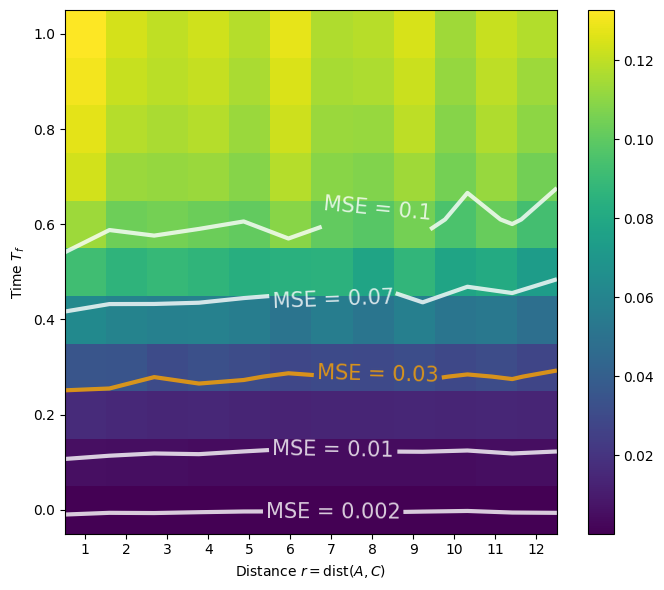

In [19]:
extent=[min(R_SCAN_RANGE)-0.5, max(R_SCAN_RANGE)+0.5, 0-0.05, 1+0.05]

fig, ax = plt.subplots(figsize=(7, 6))
im = plt.imshow(mse_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')

contour_list = [0.002, 0.01, 0.03, 0.07, 0.1]

for i in range(len(contour_list)):
    
    if i==2: color='orange' 
    else: color='white'
    
    label = r'MSE = ' + f'{contour_list[i]}' + r''
    contour = ax.contour(mse_matrix, levels=[contour_list[i]], colors=color, linewidths=3, extent=extent, alpha=0.8)
    ax.clabel(contour, fmt=label, colors=color, fontsize=15, inline=True, inline_spacing=10)

ax.set_xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
ax.set_ylabel(r'Time $T_f$')
ax.set_xticks(R_SCAN_RANGE)

plt.colorbar(im)
plt.tight_layout()
plt.show()

In [45]:
# filename = f'./results_recovery/mse_matrix_32.npy'
# np.save(filename, mse_matrix)

## 3.3 Plot Images of Digits

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.01, 0.99, 11)  # TF from 0.4 to 0.6 in 11 steps

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]
IMAGE_COUNT = 16 * 16  # 256 images in 16x16 grid

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:1]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Initialize MSE matrix: [TF_steps, R_values]
digit_matrix = torch.zeros(len(TF_SCAN_RANGE), len(R_SCAN_RANGE), 28, 28)

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)

            # print(f'{denoised_images.size()}')
            
            # Store results
            digit_matrix[tf_idx, r_idx] = denoised_images[0, 0]
            

/tmp/ipykernel_3475226/3996044684.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.0 to 1.0 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 1 test images
   Image shape: torch.Size([1, 1, 28, 28])
   Labels: 1 unique classes

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, TF=0.000, Noise_std=0.452, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 99.74it/s, TF=0.000, Noise_std=0.449, Img_range=[0.01, 0.85]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 142.03it/s, TF=-0.000, Noise_std=0.387, Img_range=[0.02, 0.75]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 135.47it/s, TF=-0.000, Noise_std=0.388, Img_range=[0.02, 0.80]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 159.78it/s, TF=-0.000, Noise_std=0.422, Img_range=[0.02, 0.76]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 124.57it/s, TF=0.000, Noise_std=0.385, Img_range=[0.03, 0.88]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 126.24it/s, TF=0.000, Noise_std=0.413, Img_range=[0.05, 0.61]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 147.02it/s, TF=0.000, Noise_std=0.375, Img_range=[0.07, 0.61]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 150.34it/s, TF=0.000, Noise_std=0.359, Img_range=[0.06, 0.39]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 142.87it/s, TF=-0.000, Noise_std=0.398, Img_range=[0.03, 0.45]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 132.28it/s, TF=0.000, Noise_std=0.431, Img_range=[0.06, 0.61]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 106.68it/s, TF=0.000, Noise_std=0.572, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 147.15it/s, TF=0.000, Noise_std=0.584, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 123.27it/s, TF=-0.000, Noise_std=0.539, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 128.31it/s, TF=-0.000, Noise_std=0.478, Img_range=[0.01, 0.70]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 136.49it/s, TF=-0.000, Noise_std=0.320, Img_range=[0.02, 0.71]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 163.67it/s, TF=0.000, Noise_std=0.232, Img_range=[0.03, 0.36]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 150.50it/s, TF=0.000, Noise_std=0.183, Img_range=[0.02, 0.37]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 151.88it/s, TF=0.000, Noise_std=0.211, Img_range=[0.01, 0.44]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 157.92it/s, TF=0.000, Noise_std=0.205, Img_range=[0.03, 0.41]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 141.05it/s, TF=-0.000, Noise_std=0.237, Img_range=[0.02, 0.45]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 140.74it/s, TF=0.000, Noise_std=0.234, Img_range=[0.03, 0.47]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 220.00it/s, TF=0.000, Noise_std=0.387, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 123.98it/s, TF=0.000, Noise_std=0.500, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 120.69it/s, TF=-0.000, Noise_std=0.480, Img_range=[0.01, 0.86]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 129.68it/s, TF=-0.000, Noise_std=0.485, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 119.44it/s, TF=-0.000, Noise_std=0.374, Img_range=[0.01, 0.68]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 119.68it/s, TF=0.000, Noise_std=0.340, Img_range=[0.00, 0.42]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 148.44it/s, TF=0.000, Noise_std=0.419, Img_range=[0.00, 0.37]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 146.00it/s, TF=0.000, Noise_std=0.327, Img_range=[0.00, 0.41]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 148.87it/s, TF=0.000, Noise_std=0.387, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 126.85it/s, TF=-0.000, Noise_std=0.338, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 144.42it/s, TF=0.000, Noise_std=0.359, Img_range=[0.00, 0.41]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 125.40it/s, TF=0.000, Noise_std=0.449, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 93.66it/s, TF=0.000, Noise_std=0.560, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 133.23it/s, TF=-0.000, Noise_std=0.518, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 131.37it/s, TF=-0.000, Noise_std=0.400, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 132.82it/s, TF=-0.000, Noise_std=0.351, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 128.65it/s, TF=0.000, Noise_std=0.325, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 133.71it/s, TF=0.000, Noise_std=0.312, Img_range=[0.00, 0.41]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 120.95it/s, TF=0.000, Noise_std=0.292, Img_range=[0.00, 0.44]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 131.83it/s, TF=0.000, Noise_std=0.299, Img_range=[0.00, 0.43]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 130.09it/s, TF=-0.000, Noise_std=0.305, Img_range=[0.00, 0.48]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 141.09it/s, TF=0.000, Noise_std=0.281, Img_range=[0.00, 0.48]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 256.93it/s, TF=0.000, Noise_std=0.457, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 138.78it/s, TF=0.000, Noise_std=0.556, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 148.54it/s, TF=-0.000, Noise_std=0.569, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 138.65it/s, TF=-0.000, Noise_std=0.476, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 141.42it/s, TF=-0.000, Noise_std=0.284, Img_range=[0.00, 0.60]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 137.65it/s, TF=0.000, Noise_std=0.240, Img_range=[0.00, 0.54]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 133.65it/s, TF=0.000, Noise_std=0.238, Img_range=[0.00, 0.56]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 136.01it/s, TF=0.000, Noise_std=0.236, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 144.30it/s, TF=0.000, Noise_std=0.229, Img_range=[0.00, 0.45]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 132.92it/s, TF=-0.000, Noise_std=0.239, Img_range=[0.00, 0.44]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 116.21it/s, TF=0.000, Noise_std=0.240, Img_range=[0.00, 0.47]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 106.34it/s, TF=0.000, Noise_std=0.412, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 108.46it/s, TF=0.000, Noise_std=0.475, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 153.55it/s, TF=-0.000, Noise_std=0.465, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 114.03it/s, TF=-0.000, Noise_std=0.434, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 126.68it/s, TF=-0.000, Noise_std=0.363, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 132.59it/s, TF=0.000, Noise_std=0.295, Img_range=[0.00, 0.60]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 118.52it/s, TF=0.000, Noise_std=0.314, Img_range=[0.00, 0.51]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 128.35it/s, TF=0.000, Noise_std=0.298, Img_range=[0.00, 0.49]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 132.27it/s, TF=0.000, Noise_std=0.297, Img_range=[0.00, 0.52]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 135.65it/s, TF=-0.000, Noise_std=0.301, Img_range=[0.00, 0.48]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 134.82it/s, TF=0.000, Noise_std=0.320, Img_range=[0.00, 0.60]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 148.23it/s, TF=0.000, Noise_std=0.407, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 119.35it/s, TF=0.000, Noise_std=0.461, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 156.10it/s, TF=-0.000, Noise_std=0.445, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 141.94it/s, TF=-0.000, Noise_std=0.438, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 156.38it/s, TF=-0.000, Noise_std=0.363, Img_range=[0.00, 0.43]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 129.02it/s, TF=0.000, Noise_std=0.280, Img_range=[0.00, 0.38]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 154.11it/s, TF=0.000, Noise_std=0.275, Img_range=[0.00, 0.39]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 134.86it/s, TF=0.000, Noise_std=0.259, Img_range=[0.00, 0.48]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 138.81it/s, TF=0.000, Noise_std=0.248, Img_range=[0.00, 0.39]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 144.23it/s, TF=-0.000, Noise_std=0.267, Img_range=[0.00, 0.41]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 135.16it/s, TF=0.000, Noise_std=0.249, Img_range=[0.00, 0.34]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 41.57it/s, TF=0.000, Noise_std=0.460, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 121.60it/s, TF=0.000, Noise_std=0.495, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 126.56it/s, TF=-0.000, Noise_std=0.459, Img_range=[0.00, 0.75]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 146.38it/s, TF=-0.000, Noise_std=0.429, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 118.27it/s, TF=-0.000, Noise_std=0.359, Img_range=[0.01, 0.61]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 109.59it/s, TF=0.000, Noise_std=0.236, Img_range=[0.01, 0.62]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 122.16it/s, TF=0.000, Noise_std=0.222, Img_range=[0.04, 0.50]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 138.24it/s, TF=0.000, Noise_std=0.217, Img_range=[0.01, 0.45]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 154.30it/s, TF=0.000, Noise_std=0.230, Img_range=[0.03, 0.52]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 128.00it/s, TF=-0.000, Noise_std=0.224, Img_range=[0.01, 0.50]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 143.86it/s, TF=0.000, Noise_std=0.191, Img_range=[0.03, 0.47]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 181.60it/s, TF=0.000, Noise_std=0.429, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 199.25it/s, TF=0.000, Noise_std=0.520, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 129.31it/s, TF=-0.000, Noise_std=0.488, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 129.04it/s, TF=-0.000, Noise_std=0.394, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 117.82it/s, TF=-0.000, Noise_std=0.344, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 158.19it/s, TF=0.000, Noise_std=0.264, Img_range=[0.00, 0.50]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 152.50it/s, TF=0.000, Noise_std=0.287, Img_range=[0.00, 0.47]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 149.38it/s, TF=0.000, Noise_std=0.248, Img_range=[0.00, 0.35]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 153.04it/s, TF=0.000, Noise_std=0.273, Img_range=[0.00, 0.36]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 144.23it/s, TF=-0.000, Noise_std=0.274, Img_range=[0.00, 0.37]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 121.67it/s, TF=0.000, Noise_std=0.262, Img_range=[0.00, 0.34]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 41.24it/s, TF=0.000, Noise_std=0.395, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 126.53it/s, TF=0.000, Noise_std=0.462, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 126.22it/s, TF=-0.000, Noise_std=0.476, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 140.91it/s, TF=-0.000, Noise_std=0.429, Img_range=[0.01, 0.63]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 137.91it/s, TF=-0.000, Noise_std=0.296, Img_range=[0.01, 0.56]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 118.66it/s, TF=0.000, Noise_std=0.269, Img_range=[0.02, 0.48]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 152.87it/s, TF=0.000, Noise_std=0.313, Img_range=[0.03, 0.41]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 153.18it/s, TF=0.000, Noise_std=0.301, Img_range=[0.05, 0.50]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 153.09it/s, TF=0.000, Noise_std=0.282, Img_range=[0.02, 0.41]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 153.42it/s, TF=-0.000, Noise_std=0.284, Img_range=[0.02, 0.39]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 154.86it/s, TF=0.000, Noise_std=0.275, Img_range=[0.02, 0.35]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 68.52it/s, TF=0.000, Noise_std=0.484, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 157.26it/s, TF=0.000, Noise_std=0.483, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 97.47it/s, TF=-0.000, Noise_std=0.445, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 137.73it/s, TF=-0.000, Noise_std=0.383, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 143.72it/s, TF=-0.000, Noise_std=0.319, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 150.33it/s, TF=0.000, Noise_std=0.274, Img_range=[0.00, 0.50]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 150.07it/s, TF=0.000, Noise_std=0.215, Img_range=[0.00, 0.39]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 139.68it/s, TF=0.000, Noise_std=0.216, Img_range=[0.00, 0.34]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 133.30it/s, TF=0.000, Noise_std=0.236, Img_range=[0.00, 0.38]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 139.71it/s, TF=-0.000, Noise_std=0.186, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 122.52it/s, TF=0.000, Noise_std=0.201, Img_range=[0.00, 0.41]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 124.17it/s, TF=0.000, Noise_std=0.424, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 150.20it/s, TF=0.000, Noise_std=0.475, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 128.54it/s, TF=-0.000, Noise_std=0.553, Img_range=[0.01, 0.76]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 153.48it/s, TF=-0.000, Noise_std=0.478, Img_range=[0.01, 0.76]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 175.31it/s, TF=-0.000, Noise_std=0.449, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 134.53it/s, TF=0.000, Noise_std=0.343, Img_range=[0.00, 0.54]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 150.99it/s, TF=0.000, Noise_std=0.324, Img_range=[0.01, 0.46]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 141.92it/s, TF=0.000, Noise_std=0.271, Img_range=[0.00, 0.44]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 156.65it/s, TF=0.000, Noise_std=0.247, Img_range=[0.01, 0.41]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 143.05it/s, TF=-0.000, Noise_std=0.279, Img_range=[0.01, 0.46]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 154.31it/s, TF=0.000, Noise_std=0.266, Img_range=[0.00, 0.37]]

Euler generation completed!


torch.Size([11, 28, 12, 28])


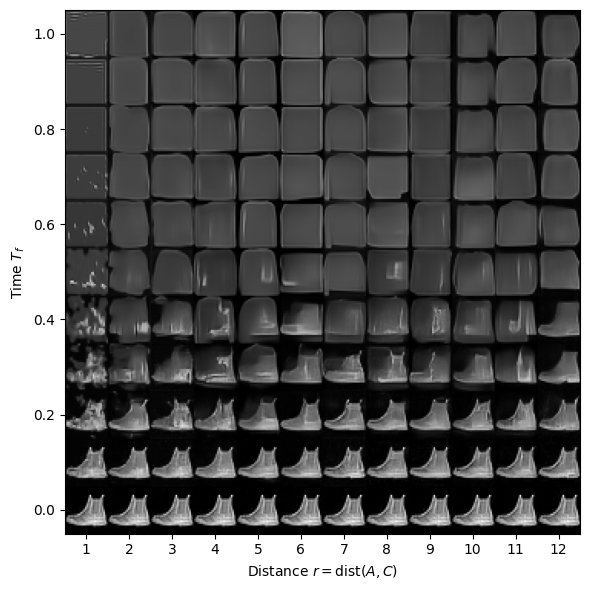

In [21]:
# Convert to 11x12 grid visualization
grid_images = digit_matrix.permute(0, 2, 1, 3)
print(f'{grid_images.size()}')
grid_images = torch.flip(grid_images, dims=[0])
grid_images = grid_images.reshape(11 * 28, 12 * 28).cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
ax = axes
ax.imshow(grid_images, aspect='auto',
         extent=[1-0.5, 12+0.5, 0-0.05, 1+0.05],
         cmap='gray', vmin=0, vmax=1)
# ax.axis('off')
# ax.plot(R_SCAN_RANGE, threshold_idx, color='red', lw=5)
ax.set_xlim([1-0.5, 12+0.5])
ax.set_ylim([0-0.05, 1+0.05])

plt.xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
plt.ylabel(r'Time $T_f$')
plt.xticks(np.array(range(1, 13)))
plt.tight_layout()
plt.show()

In [48]:
# filename = f'./results_recovery/grid_images_32.npy'
# np.save(filename, grid_images)

## 3.4 Finer Scan for $t \in [0.2, 0.5]$

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.2, 0.5, 11)  # TF from 0.4 to 0.6 in 11 steps

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]
IMAGE_COUNT = 16 * 16  # 256 images in 16x16 grid

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:1]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Create results directory
heatmap_results_dir = "./results/heatmap_analysis/"
os.makedirs(heatmap_results_dir, exist_ok=True)

# Initialize MSE matrix: [TF_steps, R_values]
digit_matrix = torch.zeros(len(TF_SCAN_RANGE), len(R_SCAN_RANGE), 28, 28)

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)

            # print(f'{denoised_images.size()}')
            
            # Store results
            digit_matrix[tf_idx, r_idx] = denoised_images[0, 0]
            

/tmp/ipykernel_3475226/1055114805.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.2 to 0.5 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 1 test images
   Image shape: torch.Size([1, 1, 28, 28])
   Labels: 1 unique classes

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps:   0%|          | 0/7 [00:00<?, ?it/s, TF=0.171, Noise_std=0.924, Img_range=[0.00, 1.00]]Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 170.48it/s, TF=-0.000, Noise_std=0.402, Img_range=[0.02, 0.82]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 174.37it/s, TF=0.000, Noise_std=0.382, Img_range=[0.02, 0.81]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 152.46it/s, TF=0.000, Noise_std=0.379, Img_range=[0.02, 0.74]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 157.16it/s, TF=0.000, Noise_std=0.377, Img_range=[0.02, 0.79]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 148.97it/s, TF=0.000, Noise_std=0.384, Img_range=[0.02, 0.73]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 164.11it/s, TF=-0.000, Noise_std=0.441, Img_range=[0.02, 0.82]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 137.54it/s, TF=0.000, Noise_std=0.422, Img_range=[0.02, 0.81]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 173.20it/s, TF=-0.000, Noise_std=0.413, Img_range=[0.02, 0.79]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 157.64it/s, TF=0.000, Noise_std=0.396, Img_range=[0.02, 0.77]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 133.57it/s, TF=0.000, Noise_std=0.398, Img_range=[0.03, 0.83]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 188.37it/s, TF=0.000, Noise_std=0.418, Img_range=[0.03, 0.84]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 141.98it/s, TF=-0.000, Noise_std=0.475, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 137.33it/s, TF=0.000, Noise_std=0.569, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 153.15it/s, TF=0.000, Noise_std=0.546, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 141.79it/s, TF=0.000, Noise_std=0.499, Img_range=[0.01, 0.69]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 164.52it/s, TF=0.000, Noise_std=0.405, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 170.77it/s, TF=-0.000, Noise_std=0.425, Img_range=[0.01, 0.71]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 151.51it/s, TF=0.000, Noise_std=0.337, Img_range=[0.01, 0.71]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 134.99it/s, TF=-0.000, Noise_std=0.300, Img_range=[0.01, 0.62]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 153.32it/s, TF=0.000, Noise_std=0.298, Img_range=[0.02, 0.69]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 162.09it/s, TF=0.000, Noise_std=0.267, Img_range=[0.01, 0.61]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 166.52it/s, TF=0.000, Noise_std=0.233, Img_range=[0.04, 0.44]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 181.81it/s, TF=-0.000, Noise_std=0.501, Img_range=[0.01, 0.76]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 152.48it/s, TF=0.000, Noise_std=0.507, Img_range=[0.01, 0.81]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 124.11it/s, TF=0.000, Noise_std=0.458, Img_range=[0.01, 0.85]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 117.83it/s, TF=0.000, Noise_std=0.493, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 167.07it/s, TF=0.000, Noise_std=0.449, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 118.29it/s, TF=-0.000, Noise_std=0.378, Img_range=[0.00, 0.63]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 132.60it/s, TF=0.000, Noise_std=0.415, Img_range=[0.01, 0.67]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 140.67it/s, TF=-0.000, Noise_std=0.375, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 118.06it/s, TF=0.000, Noise_std=0.347, Img_range=[0.00, 0.57]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 140.97it/s, TF=0.000, Noise_std=0.364, Img_range=[0.01, 0.47]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 150.70it/s, TF=0.000, Noise_std=0.335, Img_range=[0.00, 0.38]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 131.29it/s, TF=-0.000, Noise_std=0.478, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 162.52it/s, TF=0.000, Noise_std=0.521, Img_range=[0.00, 0.76]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 134.50it/s, TF=0.000, Noise_std=0.469, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 155.53it/s, TF=0.000, Noise_std=0.413, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 149.19it/s, TF=0.000, Noise_std=0.421, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 163.68it/s, TF=-0.000, Noise_std=0.368, Img_range=[0.00, 0.62]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 145.62it/s, TF=0.000, Noise_std=0.376, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 137.42it/s, TF=-0.000, Noise_std=0.350, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 136.10it/s, TF=0.000, Noise_std=0.326, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 150.86it/s, TF=0.000, Noise_std=0.340, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 164.57it/s, TF=0.000, Noise_std=0.316, Img_range=[0.00, 0.63]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 179.69it/s, TF=-0.000, Noise_std=0.519, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 131.15it/s, TF=0.000, Noise_std=0.537, Img_range=[0.00, 0.71]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 139.81it/s, TF=0.000, Noise_std=0.483, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 146.29it/s, TF=0.000, Noise_std=0.489, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 146.60it/s, TF=0.000, Noise_std=0.408, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 148.10it/s, TF=-0.000, Noise_std=0.369, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 123.03it/s, TF=0.000, Noise_std=0.365, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 139.08it/s, TF=-0.000, Noise_std=0.332, Img_range=[0.00, 0.47]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 144.80it/s, TF=0.000, Noise_std=0.285, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 131.77it/s, TF=0.000, Noise_std=0.254, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 151.61it/s, TF=0.000, Noise_std=0.257, Img_range=[0.00, 0.46]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 133.98it/s, TF=-0.000, Noise_std=0.426, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 153.19it/s, TF=0.000, Noise_std=0.425, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 149.00it/s, TF=0.000, Noise_std=0.414, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 148.40it/s, TF=0.000, Noise_std=0.456, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 147.36it/s, TF=0.000, Noise_std=0.448, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 133.64it/s, TF=-0.000, Noise_std=0.361, Img_range=[0.00, 0.61]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 133.90it/s, TF=0.000, Noise_std=0.341, Img_range=[0.00, 0.48]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 141.88it/s, TF=-0.000, Noise_std=0.345, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 150.67it/s, TF=0.000, Noise_std=0.325, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 158.46it/s, TF=0.000, Noise_std=0.321, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 152.02it/s, TF=0.000, Noise_std=0.364, Img_range=[0.00, 0.47]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 167.68it/s, TF=-0.000, Noise_std=0.429, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 135.44it/s, TF=0.000, Noise_std=0.471, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 142.65it/s, TF=0.000, Noise_std=0.426, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 152.07it/s, TF=0.000, Noise_std=0.423, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 108.23it/s, TF=0.000, Noise_std=0.422, Img_range=[0.00, 0.61]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 150.51it/s, TF=-0.000, Noise_std=0.398, Img_range=[0.00, 0.62]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 162.40it/s, TF=0.000, Noise_std=0.368, Img_range=[0.01, 0.54]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 149.39it/s, TF=-0.000, Noise_std=0.366, Img_range=[0.02, 0.57]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 145.19it/s, TF=0.000, Noise_std=0.320, Img_range=[0.01, 0.39]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 137.52it/s, TF=0.000, Noise_std=0.280, Img_range=[0.00, 0.45]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 146.11it/s, TF=0.000, Noise_std=0.296, Img_range=[0.00, 0.41]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 142.08it/s, TF=-0.000, Noise_std=0.474, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 178.39it/s, TF=0.000, Noise_std=0.437, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 149.52it/s, TF=0.000, Noise_std=0.443, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 163.22it/s, TF=0.000, Noise_std=0.443, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 168.16it/s, TF=0.000, Noise_std=0.431, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 129.70it/s, TF=-0.000, Noise_std=0.358, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 168.71it/s, TF=0.000, Noise_std=0.380, Img_range=[0.01, 0.66]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 158.15it/s, TF=-0.000, Noise_std=0.338, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 160.50it/s, TF=0.000, Noise_std=0.310, Img_range=[0.01, 0.63]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 170.11it/s, TF=0.000, Noise_std=0.260, Img_range=[0.01, 0.56]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 155.01it/s, TF=0.000, Noise_std=0.247, Img_range=[0.00, 0.55]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 169.47it/s, TF=-0.000, Noise_std=0.493, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 139.18it/s, TF=0.000, Noise_std=0.483, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 136.21it/s, TF=0.000, Noise_std=0.473, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 161.12it/s, TF=0.000, Noise_std=0.407, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 169.24it/s, TF=0.000, Noise_std=0.399, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 185.41it/s, TF=-0.000, Noise_std=0.345, Img_range=[0.00, 0.72]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 185.93it/s, TF=0.000, Noise_std=0.409, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 186.08it/s, TF=-0.000, Noise_std=0.339, Img_range=[0.00, 0.63]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 191.49it/s, TF=0.000, Noise_std=0.282, Img_range=[0.00, 0.64]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 172.07it/s, TF=0.000, Noise_std=0.316, Img_range=[0.00, 0.44]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 193.43it/s, TF=0.000, Noise_std=0.318, Img_range=[0.00, 0.39]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 182.49it/s, TF=-0.000, Noise_std=0.434, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 164.27it/s, TF=0.000, Noise_std=0.440, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 181.29it/s, TF=0.000, Noise_std=0.445, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 162.28it/s, TF=0.000, Noise_std=0.433, Img_range=[0.01, 0.64]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 177.31it/s, TF=0.000, Noise_std=0.374, Img_range=[0.01, 0.58]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 172.85it/s, TF=-0.000, Noise_std=0.330, Img_range=[0.01, 0.66]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 156.28it/s, TF=0.000, Noise_std=0.328, Img_range=[0.01, 0.63]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 134.02it/s, TF=-0.000, Noise_std=0.343, Img_range=[0.02, 0.59]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 174.63it/s, TF=0.000, Noise_std=0.287, Img_range=[0.01, 0.60]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 191.04it/s, TF=0.000, Noise_std=0.277, Img_range=[0.01, 0.51]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 169.94it/s, TF=0.000, Noise_std=0.303, Img_range=[0.02, 0.37]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 137.09it/s, TF=-0.000, Noise_std=0.457, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 195.71it/s, TF=0.000, Noise_std=0.408, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 161.35it/s, TF=0.000, Noise_std=0.419, Img_range=[0.00, 0.67]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 194.98it/s, TF=0.000, Noise_std=0.402, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 205.41it/s, TF=0.000, Noise_std=0.436, Img_range=[0.00, 0.69]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 183.73it/s, TF=-0.000, Noise_std=0.350, Img_range=[0.00, 0.66]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 161.03it/s, TF=0.000, Noise_std=0.324, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 192.92it/s, TF=-0.000, Noise_std=0.268, Img_range=[0.00, 0.63]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 197.99it/s, TF=0.000, Noise_std=0.269, Img_range=[0.00, 0.65]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 197.97it/s, TF=0.000, Noise_std=0.261, Img_range=[0.00, 0.40]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 174.28it/s, TF=0.000, Noise_std=0.279, Img_range=[0.00, 0.54]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 137.66it/s, TF=-0.000, Noise_std=0.522, Img_range=[0.01, 0.72]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 196.33it/s, TF=0.000, Noise_std=0.486, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 154.83it/s, TF=0.000, Noise_std=0.549, Img_range=[0.01, 0.70]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 185.79it/s, TF=0.000, Noise_std=0.482, Img_range=[0.01, 0.76]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 172.44it/s, TF=0.000, Noise_std=0.495, Img_range=[0.01, 0.67]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 175.37it/s, TF=-0.000, Noise_std=0.446, Img_range=[0.01, 0.68]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 183.39it/s, TF=0.000, Noise_std=0.466, Img_range=[0.00, 0.59]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 181.62it/s, TF=-0.000, Noise_std=0.381, Img_range=[0.00, 0.57]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 158.09it/s, TF=0.000, Noise_std=0.423, Img_range=[0.01, 0.57]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 168.12it/s, TF=0.000, Noise_std=0.403, Img_range=[0.01, 0.49]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 174.25it/s, TF=0.000, Noise_std=0.364, Img_range=[0.00, 0.53]]

Euler generation completed!


torch.Size([11, 28, 12, 28])


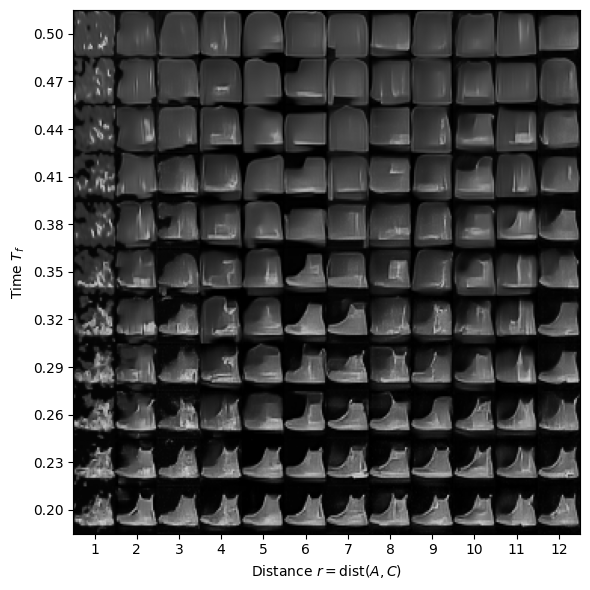

In [23]:
# Convert to 11x12 grid visualization
grid_images = digit_matrix.permute(0, 2, 1, 3)
print(f'{grid_images.size()}')
grid_images = torch.flip(grid_images, dims=[0])
grid_images = grid_images.reshape(11 * 28, 12 * 28).cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
ax = axes
ax.imshow(grid_images, aspect='auto',
         extent=[1-0.5, 12+0.5, 0.2-0.015, 0.5+0.015],
         cmap='gray', vmin=0, vmax=1)
# ax.axis('off')
# ax.plot(R_SCAN_RANGE, threshold_idx, color='red', lw=5)
ax.set_xlim([1-0.5, 12+0.5])
ax.set_ylim([0.2-0.015, 0.5+0.015])

ax.set_xticks(R_SCAN_RANGE)
ax.set_yticks(TF_SCAN_RANGE)

plt.xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
plt.ylabel(r'Time $T_f$')
# plt.xticks(np.array(range(1, 13)))
plt.tight_layout()
plt.show()

In [51]:
# filename = f'./results_recovery/grid_images_02_05_32.npy'
# np.save(filename, grid_images)